In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.kernel_approximation import RBFSampler
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import numpy as np

# Data loading
----

In [31]:
returns = pd.read_csv('../data2/lsret.csv', parse_dates=['date'], index_col='date')
returns

,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,AgeIPO,AnalystRevision,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,
1926-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-13.686396,NaN,NaN,NaN,NaN,NaN,NaN
1926-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-5.135249,NaN,NaN,NaN,NaN,NaN,NaN
1926-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.832504,NaN,NaN,NaN,NaN,NaN,NaN
1926-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-4.440908,NaN,NaN,NaN,NaN,NaN,NaN
1926-05-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.483252,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-2.811101,0.352037,-3.505424,2.124068,-3.255641,NaN,NaN,-3.993847,-8.544082,-0.468824,...,-0.572368,10.653366,10.519512,1.314790,NaN,9.055350,-2.542115,7.659403,7.117891,6.346115
2023-09-29,0.922941,-0.114425,-4.978345,-1.303447,-1.357611,NaN,NaN,-3.505014,-3.765754,-0.080998,...,0.496558,7.055164,13.252843,-2.008975,NaN,3.892683,0.505730,5.377765,2.727548,5.213919
2023-10-31,-0.134826,0.771166,-2.895934,-1.476006,-8.193653,NaN,NaN,-4.306018,-5.404844,-1.106162,...,5.018342,8.422002,9.911237,-5.063718,NaN,7.088323,-0.400864,2.923720,2.078957,3.412397


In [32]:
# Import q1 data

import pickle

with open("ls_returns_df.pkl", "rb") as f:
    ls_returns_df = pickle.load(f)

ls_returns_df.index.name = "date"
ls_returns_df


,AM,AOP,AbnormalAccruals,Accruals,AdExp,AgeIPO,AnalystRevision,AnalystValue,AnnouncementReturn,AssetGrowth,...,iomom_cust,iomom_supp,realestate,retConglomerate,roaq,skew1,tang,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,
1980-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.143644,NaN
1980-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.023398,NaN
1980-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.010369,-0.025081
1981-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.016791,-0.091380
1981-04-01,NaN,NaN,NaN,NaN,NaN,NaN,-0.009187,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.083535,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,-0.102753,0.000724,0.030043,0.067191,-0.101084,NaN,NaN,-0.086533,0.087090,-0.025627,...,NaN,NaN,0.095433,0.049514,0.020039,-0.003754,-0.042603,0.008892,0.027686,0.031552
2022-08-01,-0.008612,-0.039070,-0.004765,-0.003773,0.022900,0.157895,0.053870,-0.023717,0.168663,0.009299,...,0.069962,0.061561,0.014960,-0.021701,-0.045620,0.017262,0.044119,-0.034932,-0.049290,-0.052024
2022-09-01,-0.015784,-0.018341,-0.011092,0.015229,-0.067626,NaN,NaN,-0.009982,0.051101,0.049543,...,NaN,0.010153,-0.019127,0.059149,0.018990,0.025506,-0.032747,0.005641,0.019371,0.009875


In [33]:
with open("ls_returns_small_df.pkl", "rb") as f:
    ls_returns_small_df = pickle.load(f)

# Convert integer index to datetime and set name
ls_returns_small_df.index = pd.to_datetime(ls_returns_small_df.index, format="%Y%m")
ls_returns_small_df.index.name = "date"
ls_returns_small_df


,Beta,BetaFP,BetaTailRisk,BidAskSpread,Coskewness,DivInit,DivOmit,DolVol,ExchSwitch,FirmAge,...,ShareIss5Y,ShareVol,Spinoff,VolMkt,VolSD,VolumeTrend,std_turn,zerotrade12M,zerotrade1M,zerotrade6M
date,,,,,,,,,,,,,,,,,,,,,
1926-03-01,NaN,NaN,NaN,-0.200513,NaN,NaN,NaN,0.021639,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.040121,NaN
1926-04-01,NaN,NaN,NaN,-0.365921,NaN,NaN,NaN,-0.274993,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926-06-01,NaN,NaN,NaN,-0.175821,NaN,0.023595,NaN,-0.107338,NaN,NaN,...,NaN,-0.045364,NaN,NaN,NaN,NaN,NaN,NaN,-0.021109,NaN
1926-07-01,NaN,NaN,NaN,-0.094417,NaN,NaN,NaN,-0.113007,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007298,-0.027238
1926-08-01,NaN,NaN,NaN,0.076008,NaN,NaN,NaN,0.246736,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.251483,0.281650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,NaN,NaN,NaN,-0.083472,-0.036052,NaN,NaN,0.036163,NaN,NaN,...,NaN,NaN,NaN,-0.046534,NaN,NaN,NaN,-0.011430,0.023681,0.004350
2022-08-01,NaN,NaN,NaN,-0.015659,0.041127,NaN,NaN,0.006597,NaN,NaN,...,NaN,NaN,NaN,0.029544,NaN,NaN,NaN,0.069041,-0.009216,0.069281
2022-09-01,NaN,NaN,NaN,0.063794,-0.074914,NaN,NaN,-0.111416,NaN,NaN,...,NaN,NaN,NaN,-0.078986,NaN,NaN,NaN,-0.012275,-0.004322,-0.016190


# Cleaning
----

In [34]:
DROP_RATIO = 0.3

def clean_for_pca(df, name, max_missing_frac=DROP_RATIO):
    """Drop columns with too many NaNs, then drop rows with any remaining NaN."""
    print(f"Cleaning: {name}")
    print(f"Original shape: {df.shape}")
    
    # Step 1: Column-level missingness
    col_missing = df.isna().mean()
    cols_keep = col_missing[col_missing <= max_missing_frac].index.tolist()
    df_clean = df[cols_keep]
    
    # Step 2: Drop rows with any remaining NaN
    n_before = len(df_clean)
    df_clean = df_clean.dropna()
    print(f"Final shape: {df_clean.shape}")
    print(f"Date range: {df_clean.index[0]} to {df_clean.index[-1]}")

    print("-" * 40)
    
    return df_clean

# Clean each matrix
returns_clean = clean_for_pca(returns, "lsret.csv")
ls_large_clean = clean_for_pca(ls_returns_df, "Large-cap (Q1a)")
ls_small_clean = clean_for_pca(ls_returns_small_df, "Small-cap (Q1d)")


Cleaning: lsret.csv
Original shape: (1176, 212)
Final shape: (818, 108)
Date range: 1954-07-30 00:00:00 to 2023-08-31 00:00:00
----------------------------------------
Cleaning: Large-cap (Q1a)
Original shape: (356, 187)
Final shape: (188, 134)
Date range: 1993-06-01 00:00:00 to 2022-11-01 00:00:00
----------------------------------------
Cleaning: Small-cap (Q1d)
Original shape: (255, 47)
Final shape: (148, 15)
Date range: 1927-06-01 00:00:00 to 2022-10-01 00:00:00
----------------------------------------


# Q2 part A
----

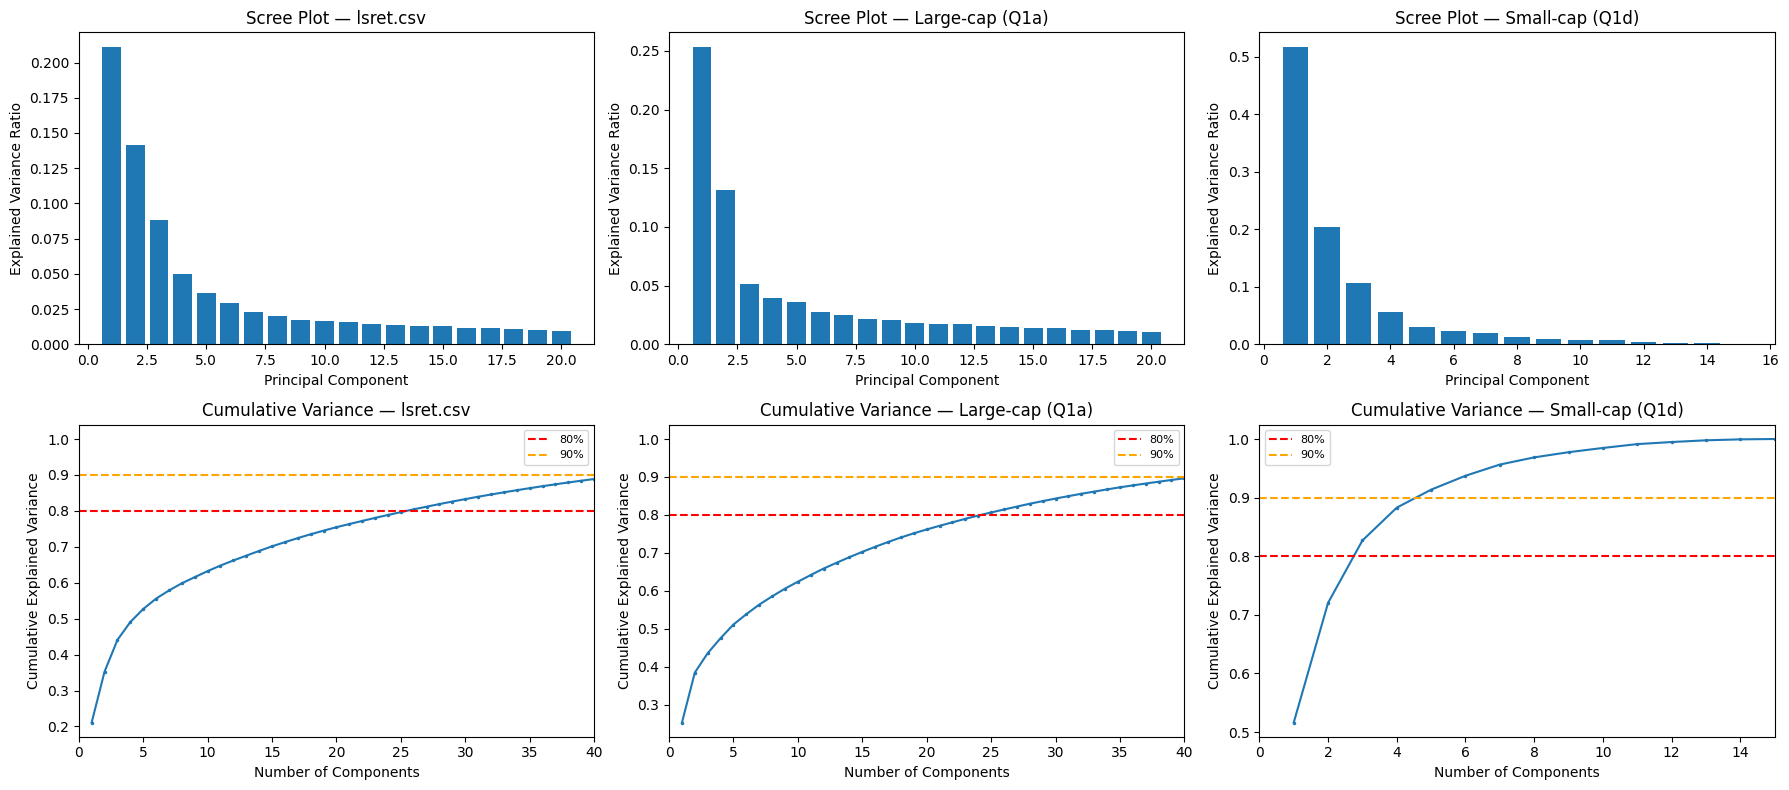

In [35]:
# ============================================================================
# PCA analysis function + run on all 3 datasets
# ============================================================================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_analysis(returns_df, name):
    """Run PCA on a cleaned returns DataFrame. Returns dict with results."""
    scaler = StandardScaler()
    returns_scaled = scaler.fit_transform(returns_df)

    pca = PCA()
    pca.fit(returns_scaled)

    cumulative_var = np.cumsum(pca.explained_variance_ratio_)

    # Use pca.n_components_ (not n_features) — when n_samples < n_features,
    # PCA produces fewer components than there are columns
    factor_returns = pd.DataFrame(
        pca.transform(returns_scaled),
        index=returns_df.index,
        columns=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    loadings = pd.DataFrame(
        pca.components_,
        columns=returns_df.columns,
        index=[f"PC{i+1}" for i in range(pca.n_components_)]
    )

    n_80 = int(np.searchsorted(cumulative_var, 0.80) + 1)
    n_90 = int(np.searchsorted(cumulative_var, 0.90) + 1)

    # Sharpe ratios for first 10 PCs
    sharpes = {}
    for i in range(min(10, factor_returns.shape[1])):
        col = f"PC{i+1}"
        mu = factor_returns[col].mean()
        sd = factor_returns[col].std(ddof=1)
        sharpes[col] = (mu / sd) * np.sqrt(12) if sd > 0 else np.nan

    return {
        "name": name,
        "pca": pca,
        "cumulative_var": cumulative_var,
        "factor_returns": factor_returns,
        "loadings": loadings,
        "n_80": n_80,
        "n_90": n_90,
        "sharpes": sharpes,
    }

# Run on all 3 datasets
datasets = [
    (returns_clean, "lsret.csv"),
    (ls_large_clean, "Large-cap (Q1a)"),
    (ls_small_clean, "Small-cap (Q1d)"),
]

pca_results = {name: pca_analysis(df, name) for df, name in datasets}

# ---- 2×3 subplot grid: scree (top row), cumulative variance (bottom row) ----
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for col_idx, (name, res) in enumerate(pca_results.items()):
    pca = res["pca"]
    cumvar = res["cumulative_var"]
    n_bars = min(20, len(pca.explained_variance_ratio_))

    # Top row: scree plot
    ax = axes[0, col_idx]
    ax.bar(range(1, n_bars + 1), pca.explained_variance_ratio_[:n_bars])
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance Ratio")
    ax.set_title(f"Scree Plot — {name}")

    # Bottom row: cumulative variance
    ax = axes[1, col_idx]
    ax.plot(range(1, len(cumvar) + 1), cumvar, marker='.', markersize=3)
    ax.axhline(y=0.8, color='r', linestyle='--', label='80%')
    ax.axhline(y=0.9, color='orange', linestyle='--', label='90%')
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Cumulative Explained Variance")
    ax.set_title(f"Cumulative Variance — {name}")
    ax.legend(fontsize=8)
    ax.set_xlim(0, min(40, len(cumvar)))

plt.tight_layout()
plt.show()

In [36]:
# ============================================================================
# Interpret PCs: top loadings for first 3 PCs of each dataset
# ============================================================================

for name, res in pca_results.items():
    loadings = res["loadings"]
    pca = res["pca"]
    n_pcs = min(3, loadings.shape[0])

    print(f"\n{'#'*60}")
    print(f"  {name}")
    print(f"{'#'*60}")

    for i in range(n_pcs):
        pc = f"PC{i+1}"
        sorted_loadings = loadings.loc[pc].sort_values()
        var_pct = pca.explained_variance_ratio_[i] * 100

        print(f"\n{pc} ({var_pct:.1f}% of variance)")
        print(f"  NEGATIVE loadings: {dict(sorted_loadings.head(5).round(3))}")
        print(f"  POSITIVE loadings: {dict(sorted_loadings.tail(5).round(3))}")


############################################################
  lsret.csv
############################################################

PC1 (21.1% of variance)
  NEGATIVE loadings: {'IdioVolAHT': np.float64(-0.183), 'IdioVol3F': np.float64(-0.179), 'RealizedVol': np.float64(-0.177), 'ShareIss5Y': np.float64(-0.176), 'MaxRet': np.float64(-0.17)}
  POSITIVE loadings: {'RD': np.float64(0.156), 'Price': np.float64(0.158), 'BidAskSpread': np.float64(0.174), 'BetaFP': np.float64(0.177), 'Beta': np.float64(0.191)}

PC2 (14.1% of variance)
  NEGATIVE loadings: {'VarCF': np.float64(-0.115), 'EarningsConsistency': np.float64(-0.112), 'GrSaleToGrOverhead': np.float64(-0.085), 'CompEquIss': np.float64(-0.083), 'Mom12m': np.float64(-0.076)}
  POSITIVE loadings: {'BM': np.float64(0.188), 'DelCOA': np.float64(0.188), 'MomOffSeason': np.float64(0.198), 'InvestPPEInv': np.float64(0.202), 'DolVol': np.float64(0.202)}

PC3 (8.8% of variance)
  NEGATIVE loadings: {'CashProd': np.float64(-0.21), 'SP': np.f

#### Q2a i
From the computation and charts above - for large cap stocks and the lsret portfilios around 25 factors are needed to reach 80% variance explanation. 

For small cap much less are needed - 3 PC's are needed to reach 80%.

#### Q2a ii

lsret.csv/large cap factors:
    - PC1: a risk/volatility factor -> general market move impact on characteristic portfolios
    - PC2: value/investment factor -> presence of book-to-market and other similar characteristics point to a classic Fama HML factor
    - PC3: momentum factor

small cap:
    - PC1: risk/vol factor
    - PC2: trading attention factor -> stocks in the center of attention due to news that are trading actively
    - PC3: tail asymmetry/crash sensitivity

#### Q2a ii

PC1 explains the most variance but often has a mediocre Sharpe — it captures common risk (market-like), which is volatile but not necessarily has a high sharpe.

A later PC can have higher sharpe because it captures a smaller, more consistent feature.

# Q2 part b
---

Train: 583 months (1954-07 to 2003-12)
Test:  235 months (2004-01 to 2023-08)

Lasso alpha: 0.025081  (non-zero coefs: 32/108)
Ridge alpha: 0.001000

Out-of-Sample Annualized Sharpe Ratios (2004+)
  Lasso: 1.840
  Ridge: 1.717


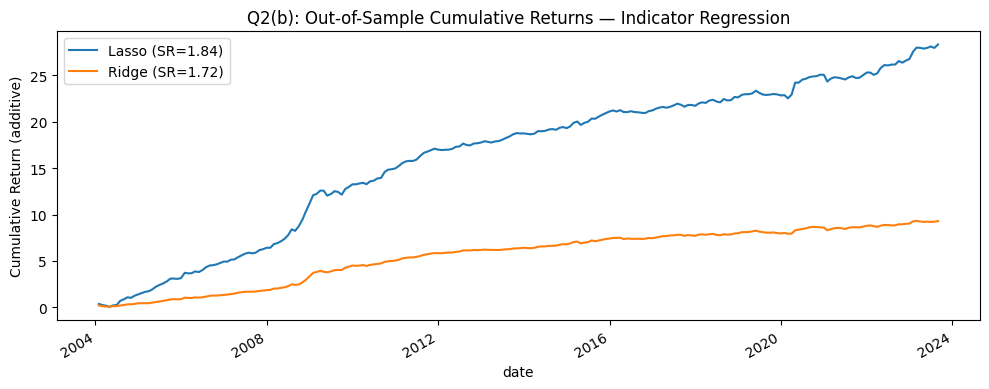

In [37]:
from sklearn.linear_model import LassoCV, RidgeCV

# fit_intercept=False: forces the model to use returns to hit the target
# with_mean=False: do NOT center features — the mean returns ARE the signal

# Use the cleaned lsret returns — convert to decimal
X = returns_clean.copy() / 100
y = pd.Series(1.0, index=X.index, name="indicator")

# Split: pre-2004 = train, 2004+ = test
train_mask = X.index < "2004-01-01"
test_mask = ~train_mask

X_train, y_train = X[train_mask], y[train_mask]
X_test = X[test_mask]

print(f"Train: {X_train.shape[0]} months ({X_train.index[0].strftime('%Y-%m')} to {X_train.index[-1].strftime('%Y-%m')})")
print(f"Test:  {X_test.shape[0]} months ({X_test.index[0].strftime('%Y-%m')} to {X_test.index[-1].strftime('%Y-%m')})")

# Scale by std only — do NOT center (centering removes the mean signal)
scaler = StandardScaler(with_mean=False)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Fit Lasso and Ridge — NO INTERCEPT
lasso = LassoCV(cv=5, max_iter=200000, fit_intercept=False, random_state=0).fit(X_train_sc, y_train)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5, fit_intercept=False).fit(X_train_sc, y_train)

print(f"\nLasso alpha: {lasso.alpha_:.6f}  (non-zero coefs: {np.sum(lasso.coef_ != 0)}/{len(lasso.coef_)})")
print(f"Ridge alpha: {ridge.alpha_:.6f}")

# Out-of-sample portfolio returns = X_test @ coefficients
# Normalize to unit leverage for interpretable scale
lasso_raw = X_test_sc @ lasso.coef_
ridge_raw = X_test_sc @ ridge.coef_

lasso_oos = pd.Series(lasso_raw / np.sum(np.abs(lasso.coef_)), index=X_test.index)
ridge_oos = pd.Series(ridge_raw / np.sum(np.abs(ridge.coef_)), index=X_test.index)

def annualized_sharpe(r):
    mu = r.mean()
    sd = r.std(ddof=1)
    if sd == 0:
        return np.nan
    return (mu / sd) * np.sqrt(12)

sr_lasso = annualized_sharpe(lasso_oos)
sr_ridge = annualized_sharpe(ridge_oos)

print(f"\n{'='*50}")
print(f"Out-of-Sample Annualized Sharpe Ratios (2004+)")
print(f"{'='*50}")
print(f"  Lasso: {sr_lasso:.3f}")
print(f"  Ridge: {sr_ridge:.3f}")

# Cumulative SUM plot (standard for long-short portfolios)
fig, ax = plt.subplots(figsize=(10, 4))
lasso_oos.cumsum().plot(ax=ax, label=f"Lasso (SR={sr_lasso:.2f})")
ridge_oos.cumsum().plot(ax=ax, label=f"Ridge (SR={sr_ridge:.2f})")
ax.set_title("Q2(b): Out-of-Sample Cumulative Returns — Indicator Regression")
ax.set_ylabel("Cumulative Return (additive)")
ax.legend()
plt.tight_layout()
plt.show()


# Q2 part c
---

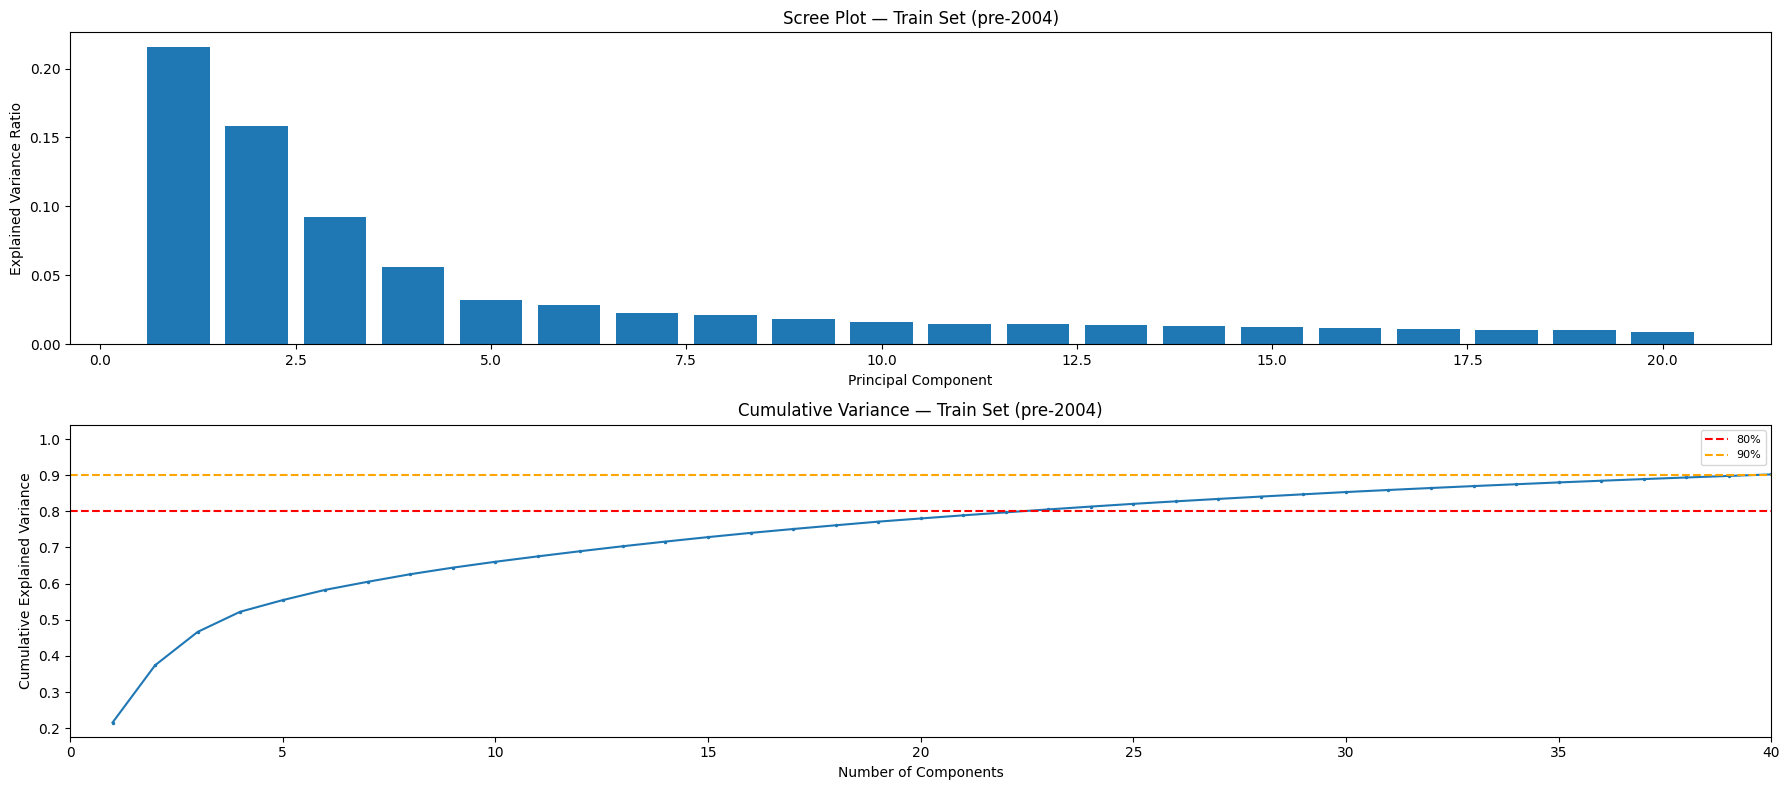

In [38]:
pca_results_train = pca_analysis(X_train, "Train Set (pre-2004)")

fig, axes = plt.subplots(2, 1, figsize=(18, 8))

pca_train = pca_results_train["pca"]
cumvar = pca_results_train["cumulative_var"]
n_bars = min(20, len(pca_train.explained_variance_ratio_))

# Top: scree plot
ax = axes[0]
ax.bar(range(1, n_bars + 1), pca_train.explained_variance_ratio_[:n_bars])
ax.set_xlabel("Principal Component")
ax.set_ylabel("Explained Variance Ratio")
ax.set_title("Scree Plot — Train Set (pre-2004)")

# Bottom: cumulative variance
ax = axes[1]
ax.plot(range(1, len(cumvar) + 1), cumvar, marker='.', markersize=3)
ax.axhline(y=0.8, color='r', linestyle='--', label='80%')
ax.axhline(y=0.9, color='orange', linestyle='--', label='90%')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Cumulative Explained Variance")
ax.set_title("Cumulative Variance — Train Set (pre-2004)")
ax.legend(fontsize=8)
ax.set_xlim(0, min(40, len(cumvar)))

plt.tight_layout()
plt.show()

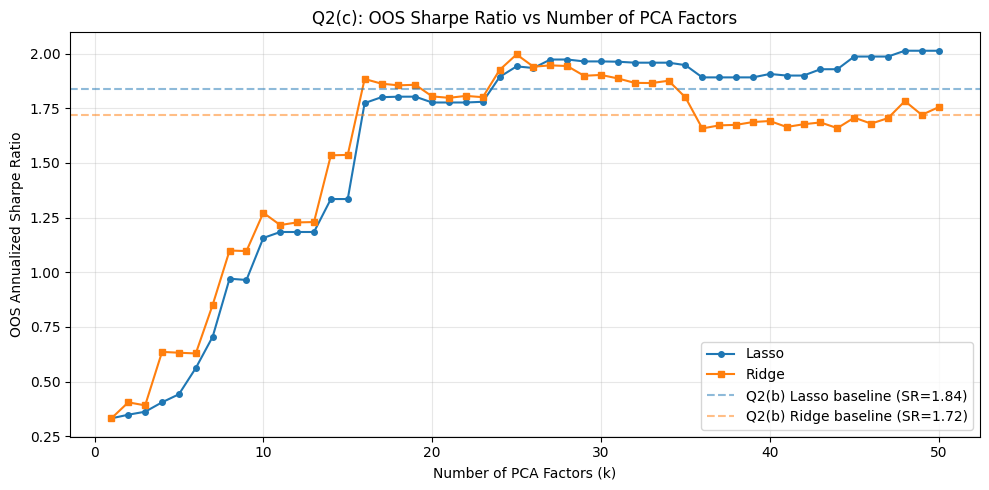

Best Lasso:  k=48,  SR=2.013
Best Ridge:  k=25,  SR=1.996

Q2(b) baselines (all 108 portfolios):
  Lasso: SR=1.840   Ridge: SR=1.717


In [39]:
# ============================================================================
# Q2(c): Sweep over number of PCA factors — indicator regression
# ============================================================================
# Key: scale by std only (with_mean=False) so mean returns are preserved.
# PCA finds the principal directions; we project the UN-CENTERED scaled data
# onto them so that indicator regression can exploit the mean signal.

# Scale by std only (same philosophy as Q2b)
scaler_c = StandardScaler(with_mean=False)
X_train_sc_c = scaler_c.fit_transform(X_train)
X_test_sc_c  = scaler_c.transform(X_test)

# Fit full PCA on training data (sklearn internally centers for SVD,
# but we only use the components_ / eigenvectors)
pca_c = PCA().fit(X_train_sc_c)

max_k = 50
ks = list(range(1, max_k + 1))
sharpes_lasso_c = []
sharpes_ridge_c = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for k in ks:
        # Project UNCENTERED scaled data onto first k eigenvectors
        V_k = pca_c.components_[:k].T          # (n_features, k)
        Z_train = X_train_sc_c @ V_k
        Z_test  = X_test_sc_c  @ V_k

        # ---- Lasso ----
        lasso_k = LassoCV(cv=5, max_iter=200000,
                          fit_intercept=False, random_state=0)
        lasso_k.fit(Z_train, y_train)
        lasso_raw = Z_test @ lasso_k.coef_
        lev = np.sum(np.abs(lasso_k.coef_))
        sharpes_lasso_c.append(
            annualized_sharpe(pd.Series(lasso_raw / lev)) if lev > 0 else np.nan
        )

        # ---- Ridge ----
        ridge_k = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5,
                          fit_intercept=False)
        ridge_k.fit(Z_train, y_train)
        ridge_raw = Z_test @ ridge_k.coef_
        lev = np.sum(np.abs(ridge_k.coef_))
        sharpes_ridge_c.append(
            annualized_sharpe(pd.Series(ridge_raw / lev)) if lev > 0 else np.nan
        )

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(ks, sharpes_lasso_c, marker='o', markersize=4, label='Lasso')
ax.plot(ks, sharpes_ridge_c, marker='s', markersize=4, label='Ridge')
ax.axhline(y=sr_lasso, color='C0', linestyle='--', alpha=0.5,
           label=f'Q2(b) Lasso baseline (SR={sr_lasso:.2f})')
ax.axhline(y=sr_ridge, color='C1', linestyle='--', alpha=0.5,
           label=f'Q2(b) Ridge baseline (SR={sr_ridge:.2f})')
ax.set_xlabel('Number of PCA Factors (k)')
ax.set_ylabel('OOS Annualized Sharpe Ratio')
ax.set_title('Q2(c): OOS Sharpe Ratio vs Number of PCA Factors')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary
best_k_l = ks[int(np.nanargmax(sharpes_lasso_c))]
best_k_r = ks[int(np.nanargmax(sharpes_ridge_c))]
print(f"Best Lasso:  k={best_k_l},  SR={np.nanmax(sharpes_lasso_c):.3f}")
print(f"Best Ridge:  k={best_k_r},  SR={np.nanmax(sharpes_ridge_c):.3f}")
print(f"\nQ2(b) baselines (all 108 portfolios):")
print(f"  Lasso: SR={sr_lasso:.3f}   Ridge: SR={sr_ridge:.3f}")

Some conclusions we can draw from the data:

PCA helps Ridge more than Lasso due to shrinkage but Lasso wins since due to the ability to zero out features. Sharpe optimized at k ~ 15 and maximized at k ~ 24

# Q2 part d
---
## large cap


  Large-cap (Q1a)
Train: (58, 134) (1993-06 to 2003-12)
Test:  (130, 134) (2004-03 to 2022-11)
Lasso alpha: 0.179189  (non-zero: 3/134)
Ridge alpha: 0.001000
OOS Sharpe — Lasso: 10.100,  Ridge: 6.523


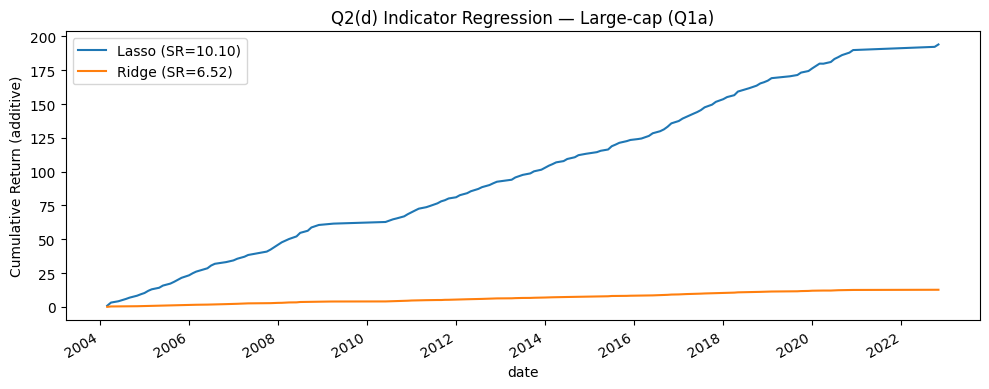

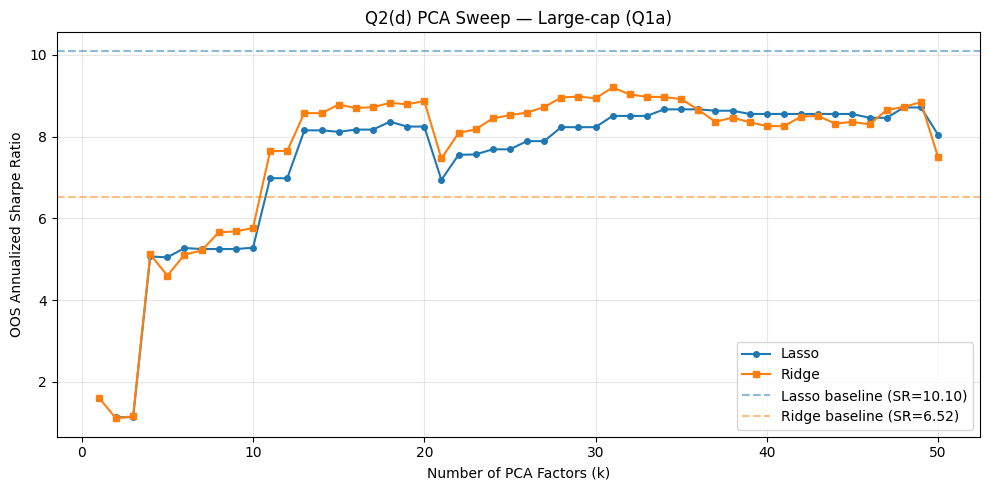

Best Lasso:  k=49,  SR=8.712
Best Ridge:  k=31,  SR=9.200
Baselines — Lasso: 10.100,  Ridge: 6.523

  Small-cap (Q1d)
Train: (128, 15) (1927-06 to 1994-02)
Test:  (20, 15) (2017-01 to 2022-10)
Lasso alpha: 0.266432  (non-zero: 2/15)
Ridge alpha: 0.001000
OOS Sharpe — Lasso: 2.602,  Ridge: 3.699


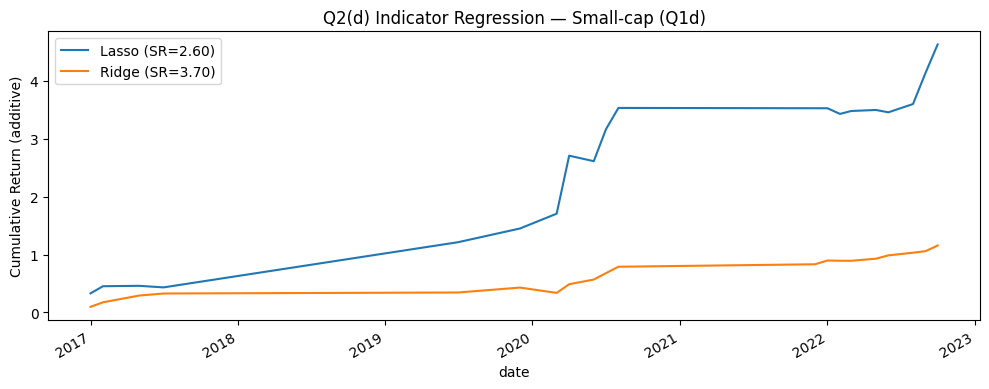

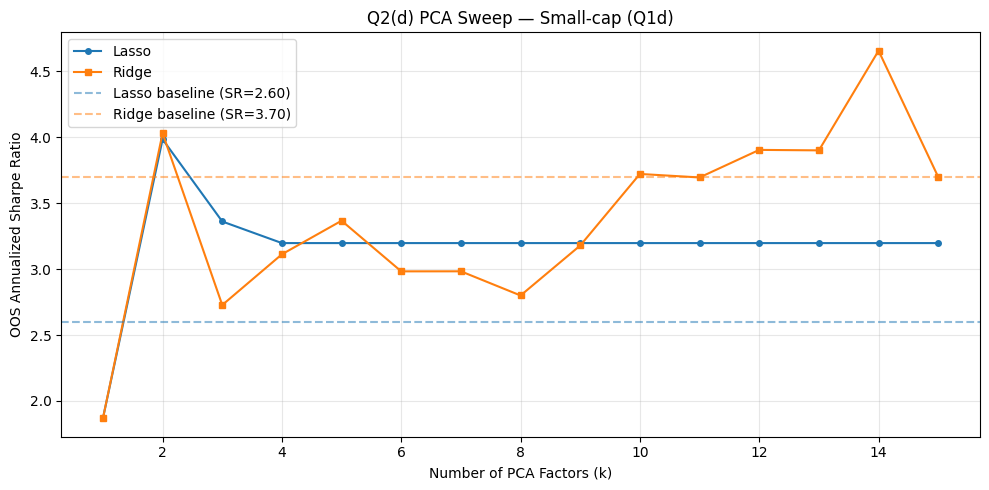

Best Lasso:  k=2,  SR=3.985
Best Ridge:  k=14,  SR=4.657
Baselines — Lasso: 2.602,  Ridge: 3.699


In [40]:
# ============================================================================
# Q2(d): Repeat Q2(b) + Q2(c) for large-cap and small-cap portfolios
# ============================================================================
# Note: large-cap and small-cap returns are already in DECIMALS (not pct pts)

def run_indicator_and_pca_sweep(returns_df, name, train_cutoff="2004-01-01"):
    """Run Q2(b) indicator regression + Q2(c) PCA sweep on a given dataset."""

    X = returns_df.copy()  # already in decimals
    y = pd.Series(1.0, index=X.index)

    train_mask = X.index < train_cutoff
    X_train, y_train = X[train_mask], y[train_mask]
    X_test = X[~train_mask]

    print(f"\n{'='*60}")
    print(f"  {name}")
    print(f"{'='*60}")
    print(f"Train: {X_train.shape} ({X_train.index[0].strftime('%Y-%m')} to {X_train.index[-1].strftime('%Y-%m')})")
    print(f"Test:  {X_test.shape} ({X_test.index[0].strftime('%Y-%m')} to {X_test.index[-1].strftime('%Y-%m')})")

    # --- Q2(b): Indicator regression on raw portfolios ---
    scaler = StandardScaler(with_mean=False)
    X_train_sc = scaler.fit_transform(X_train)
    X_test_sc = scaler.transform(X_test)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lasso = LassoCV(cv=5, max_iter=200000, fit_intercept=False,
                        random_state=0).fit(X_train_sc, y_train)
        ridge = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5,
                        fit_intercept=False).fit(X_train_sc, y_train)

    print(f"Lasso alpha: {lasso.alpha_:.6f}  (non-zero: {np.sum(lasso.coef_ != 0)}/{len(lasso.coef_)})")
    print(f"Ridge alpha: {ridge.alpha_:.6f}")

    # OOS returns (unit leverage)
    lasso_raw = X_test_sc @ lasso.coef_
    ridge_raw = X_test_sc @ ridge.coef_
    lev_l = np.sum(np.abs(lasso.coef_))
    lev_r = np.sum(np.abs(ridge.coef_))
    lasso_oos = pd.Series(lasso_raw / lev_l if lev_l > 0 else lasso_raw, index=X_test.index)
    ridge_oos = pd.Series(ridge_raw / lev_r if lev_r > 0 else ridge_raw, index=X_test.index)

    sr_l_base = annualized_sharpe(lasso_oos)
    sr_r_base = annualized_sharpe(ridge_oos)
    print(f"OOS Sharpe — Lasso: {sr_l_base:.3f},  Ridge: {sr_r_base:.3f}")

    # Cumulative return plot
    fig, ax = plt.subplots(figsize=(10, 4))
    lasso_oos.cumsum().plot(ax=ax, label=f"Lasso (SR={sr_l_base:.2f})")
    ridge_oos.cumsum().plot(ax=ax, label=f"Ridge (SR={sr_r_base:.2f})")
    ax.set_title(f"Q2(d) Indicator Regression — {name}")
    ax.set_ylabel("Cumulative Return (additive)")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # --- Q2(c): PCA sweep ---
    pca_full = PCA().fit(X_train_sc)
    n_components = pca_full.n_components_
    max_k = min(50, n_components)
    ks = list(range(1, max_k + 1))
    sharpes_lasso = []
    sharpes_ridge = []

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for k in ks:
            V_k = pca_full.components_[:k].T
            Z_train = X_train_sc @ V_k
            Z_test  = X_test_sc  @ V_k

            lasso_k = LassoCV(cv=5, max_iter=200000, fit_intercept=False,
                              random_state=0)
            lasso_k.fit(Z_train, y_train)
            lasso_raw_k = Z_test @ lasso_k.coef_
            lev = np.sum(np.abs(lasso_k.coef_))
            sharpes_lasso.append(
                annualized_sharpe(pd.Series(lasso_raw_k / lev)) if lev > 0 else np.nan
            )

            ridge_k = RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5,
                              fit_intercept=False)
            ridge_k.fit(Z_train, y_train)
            ridge_raw_k = Z_test @ ridge_k.coef_
            lev = np.sum(np.abs(ridge_k.coef_))
            sharpes_ridge.append(
                annualized_sharpe(pd.Series(ridge_raw_k / lev)) if lev > 0 else np.nan
            )

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(ks, sharpes_lasso, marker='o', markersize=4, label='Lasso')
    ax.plot(ks, sharpes_ridge, marker='s', markersize=4, label='Ridge')
    ax.axhline(y=sr_l_base, color='C0', linestyle='--', alpha=0.5,
               label=f'Lasso baseline (SR={sr_l_base:.2f})')
    ax.axhline(y=sr_r_base, color='C1', linestyle='--', alpha=0.5,
               label=f'Ridge baseline (SR={sr_r_base:.2f})')
    ax.set_xlabel('Number of PCA Factors (k)')
    ax.set_ylabel('OOS Annualized Sharpe Ratio')
    ax.set_title(f'Q2(d) PCA Sweep — {name}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    best_k_l = ks[int(np.nanargmax(sharpes_lasso))]
    best_k_r = ks[int(np.nanargmax(sharpes_ridge))]
    print(f"Best Lasso:  k={best_k_l},  SR={np.nanmax(sharpes_lasso):.3f}")
    print(f"Best Ridge:  k={best_k_r},  SR={np.nanmax(sharpes_ridge):.3f}")
    print(f"Baselines — Lasso: {sr_l_base:.3f},  Ridge: {sr_r_base:.3f}")

# Run for both datasets
run_indicator_and_pca_sweep(ls_large_clean, "Large-cap (Q1a)")
run_indicator_and_pca_sweep(ls_small_clean, "Small-cap (Q1d)")

### Analysis of above

The results are not surprising given the PCA preformed in part A. small cap have fewer factors responsible for much of the sharpe.

etc...

# Q2 part e
---